==================================softmax-regression.md========================================

=============================================image-classification-dataset.md======================================================

In [2]:
%matplotlib inline
import time
from d2l import torch as d2l
import torch
import torchvision
from torchvision import transforms

d2l.use_svg_display()

In [3]:
class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)

data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



(60000, 10000)

In [6]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val), data.train[0][0].shape #c*h*w


(60000, 10000, torch.Size([1, 32, 32]))

In [7]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [9]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

In [10]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [11]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'6.61 sec'

In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    raise NotImplementedError

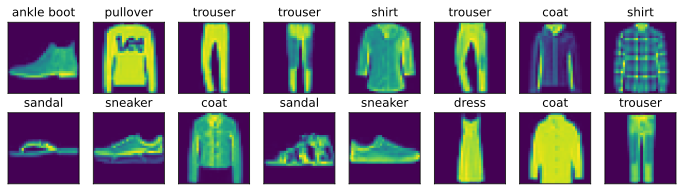

In [16]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch, nrows=2, ncols=8)

In [15]:
X, y = batch
X.shape, X.squeeze(1).shape, y.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 32, 32]), torch.Size([64]))

==================================base-classification-model.md==============================

In [19]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])  # batch = (X, y), so batch[:-1] = (X,) 
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [20]:
# explain * on tuples
batch = (X, )  # Single element tuple
# result = self(*batch) // Equivalent to: self(X) - unpacks and passes X as argument


batch = (X, y)  # Two element tuple
# result = self(*batch) # Equivalent to: self(X, y) - unpacks and passes X and y as separate arguments

In [17]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [21]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

============================= Softmax-Regression-Implementation-from-Scratch.md=========================

In [22]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [24]:
def softmax(X): # each row is an example
    """Softmax function."""
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [25]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1953, 0.2660, 0.2516, 0.1626, 0.1245],
         [0.1752, 0.1564, 0.1646, 0.2142, 0.2895]]),
 tensor([1., 1.]))

In [26]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [27]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [31]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])

# Equivalent to: y_hat[[0, 1], [0, 2]]
y_hat[[0, 1], y] # This is advanced indexing: [row_indices [0,1], column_indices [0, 2]]


tensor([0.1000, 0.5000])

In [30]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [ ]:

@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

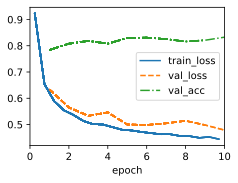

In [32]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [40]:
# Prediction

X, y = next(iter(data.val_dataloader()))
tmp = model(X) #__call__ method will invoke forward function
preds = tmp.argmax(axis=1)
tmp.shape,preds.shape

(torch.Size([256, 10]), torch.Size([256]))

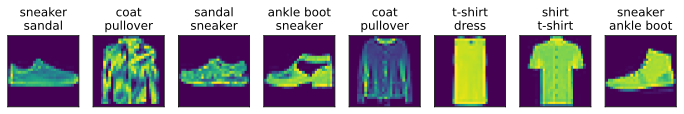

In [41]:
# We are more interested in the images we label incorrectly. We visualize them by comparing their actual labels (first line of text output) with the predictions from the model (second line of text output).
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

===========================Concise-Implementation-of-Softmax-Regression.md========================================

In [44]:
from torch import nn
from torch.nn import functional as F


In [45]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X) # ‚Üê Returns logits (no softmax)

In [46]:
# F.cross_entropy internally performs:
# 1. Apply softmax to Y_hat (logits ‚Üí probabilities)
# 2. Compute cross-entropy loss
# 3. Return the loss

# Equivalent to:
# probabilities = F.softmax(Y_hat, dim=1)
# loss = F.nll_loss(torch.log(probabilities), Y)

# And the softmax function is an improved version which will reduce average before applying exponentiation, which avoids both overflow and underflow.
# like
# def softmax(x, dim):
#     # subtract max for numerical stability
#     x_exp = torch.exp(x - x.max(dim=dim, keepdim=True).values)
#     return x_exp / x_exp.sum(dim=dim, keepdim=True)

@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))  # This reshapes Y_hat to 2D format: (total_samples, num_classes)
    Y = Y.reshape((-1,)) # flattens the tensor to 1D, regardless of its original shape.
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')


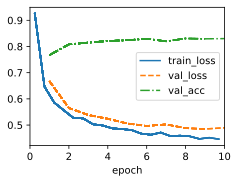

In [47]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

===========================Generalization-in-Classificationmd========================

In [48]:
# Multiple hypothesis testing ‚Üí testing many classifiers on the same test set increases the chance of false discoveries (misleadingly good results).

# Adaptive overfitting ‚Üí once test set performance influences future model choices, the test set is no longer unbiased.

## Three-Way Split Solution for Adaptive Overfitting

### üéØThree-way split is the standard solution to prevent adaptive overfitting**

#### **The Problem:**
- **Two-way split**: Train ‚Üí Validation (used for both model selection AND evaluation)
- **Result**: Model selection process "overfits" to validation set
- **Consequence**: Overly optimistic performance estimates

#### **The Solution: Three-Way Split**

```python
# Traditional (problematic):
Data = Training Set (60%) + Validation Set (40%)
#      ‚Üì                    ‚Üì
#   Train model         Select best model + Evaluate
#                       (Same data used twice! ‚ùå)

# Three-way split (proper):
Data = Training Set (60%) + Validation Set (20%) + Test Set (20%)
#      ‚Üì                    ‚Üì                       ‚Üì
#   Train model         Select best model      Final evaluation
#   (Learn params)      (Tune hyperparams)     (Unbiased estimate)
```

#### **Usage Protocol:**
1. **Training Set**: Train multiple models/configurations
2. **Validation Set**: Compare models, tune hyperparameters, select best
3. **Test Set**: Final evaluation **ONLY ONCE** on the chosen model

#### **Why This Works:**
- **Validation set bias** is contained to model selection phase
- **Test set remains "unseen"** throughout development
- **True generalization** is measured on completely independent data

#### **Alternative Solutions:**
- **Cross-validation**: Reduces validation set overfitting with multiple folds
- **Nested cross-validation**: Even more robust for small datasets
- **Holdout validation**: Strict discipline in test set usage

üí° COVARIATE SHIFT
üìã Definition:
‚Ä¢ Input distribution changes: P_train(X) ‚â† P_test(X)
‚Ä¢ Relationship stays same: P_train(Y|X) = P_test(Y|X)

üé≠ Example:
‚Ä¢ Training: Professional photos (high quality)
‚Ä¢ Testing: Phone camera pics (varied quality)
‚Ä¢ Same objects, different image characteristics

‚ö†Ô∏è  Problem:
‚Ä¢ Model expects training-like inputs
‚Ä¢ Performance drops on different input distributions
‚Ä¢ Decision boundaries may be suboptimal

üí° Solutions:
‚Ä¢ Domain adaptation (align distributions)
‚Ä¢ Importance weighting (reweight training data)
‚Ä¢ Collect diverse training data

üéØ Key Insight:
Your input data 'looks different' but the rules haven't changed! 


In [53]:
# üìä LABEL SHIFT - Concise Explanation

print("="*60)
print("üí° LABEL SHIFT (PRIOR SHIFT)")
print("="*60)

print("üìã Definition:")
print("‚Ä¢ Label distribution changes: P_train(Y) ‚â† P_test(Y)")
print("‚Ä¢ Feature given label stays same: P_train(X|Y) = P_test(X|Y)")

print(f"\nüé≠ Example:")
print("‚Ä¢ Training: 50% cats, 50% dogs")
print("‚Ä¢ Testing: 80% cats, 20% dogs")
print("‚Ä¢ Same image features per class, different class proportions")

print(f"\n‚ö†Ô∏è  Problem:")
print("‚Ä¢ Model calibrated for training class frequencies")
print("‚Ä¢ Prediction bias toward training-frequent classes")
print("‚Ä¢ Confidence scores may be miscalibrated")

print(f"\nüí° Solutions:")
print("‚Ä¢ Reweight loss by inverse class frequency")
print("‚Ä¢ Post-hoc calibration of predictions")
print("‚Ä¢ Importance weighting based on P_test(Y)/P_train(Y)")

print(f"\nüîÑ vs Covariate Shift:")
print("‚Ä¢ Label Shift: Class proportions change")
print("‚Ä¢ Covariate Shift: Input characteristics change")

print(f"\nüéØ Key Insight:")
print("Same classes, different frequencies!")

üí° LABEL SHIFT (PRIOR SHIFT)
üìã Definition:
‚Ä¢ Label distribution changes: P_train(Y) ‚â† P_test(Y)
‚Ä¢ Feature given label stays same: P_train(X|Y) = P_test(X|Y)

üé≠ Example:
‚Ä¢ Training: 50% cats, 50% dogs
‚Ä¢ Testing: 80% cats, 20% dogs
‚Ä¢ Same image features per class, different class proportions

‚ö†Ô∏è  Problem:
‚Ä¢ Model calibrated for training class frequencies
‚Ä¢ Prediction bias toward training-frequent classes
‚Ä¢ Confidence scores may be miscalibrated

üí° Solutions:
‚Ä¢ Reweight loss by inverse class frequency
‚Ä¢ Post-hoc calibration of predictions
‚Ä¢ Importance weighting based on P_test(Y)/P_train(Y)

üîÑ vs Covariate Shift:
‚Ä¢ Label Shift: Class proportions change
‚Ä¢ Covariate Shift: Input characteristics change

üéØ Key Insight:
Same classes, different frequencies!


In [54]:
# üåä CONCEPT SHIFT (CONCEPT DRIFT) - Concise Explanation

print("="*60)
print("üí° CONCEPT SHIFT (CONCEPT DRIFT)")
print("="*60)

print("üìã Definition:")
print("‚Ä¢ Relationship changes: P_train(Y|X) ‚â† P_test(Y|X)")
print("‚Ä¢ Input distribution may stay same: P_train(X) = P_test(X)")

print(f"\nüé≠ Example:")
print("‚Ä¢ Training: Email spam detection (2020 patterns)")
print("‚Ä¢ Testing: Same email features, but spam tactics evolved (2024)")
print("‚Ä¢ Same input types, but meaning/relationship changed")

print(f"\n‚ö†Ô∏è  Problem:")
print("‚Ä¢ Model learns outdated relationships")
print("‚Ä¢ Decision rules become obsolete over time")
print("‚Ä¢ Most challenging type of distribution shift")

print(f"\nüí° Solutions:")
print("‚Ä¢ Online learning (continuous model updates)")
print("‚Ä¢ Regular model retraining with fresh data")
print("‚Ä¢ Ensemble methods with time-weighted models")
print("‚Ä¢ Drift detection and automatic retraining")

print(f"\nüîÑ vs Other Shifts:")
print("‚Ä¢ Concept Shift: Rules/relationships change")
print("‚Ä¢ Covariate Shift: Input characteristics change")
print("‚Ä¢ Label Shift: Class proportions change")

print(f"\nüéØ Key Insight:")
print("The world changed - same inputs, new rules!")

üí° CONCEPT SHIFT (CONCEPT DRIFT)
üìã Definition:
‚Ä¢ Relationship changes: P_train(Y|X) ‚â† P_test(Y|X)
‚Ä¢ Input distribution may stay same: P_train(X) = P_test(X)

üé≠ Example:
‚Ä¢ Training: Email spam detection (2020 patterns)
‚Ä¢ Testing: Same email features, but spam tactics evolved (2024)
‚Ä¢ Same input types, but meaning/relationship changed

‚ö†Ô∏è  Problem:
‚Ä¢ Model learns outdated relationships
‚Ä¢ Decision rules become obsolete over time
‚Ä¢ Most challenging type of distribution shift

üí° Solutions:
‚Ä¢ Online learning (continuous model updates)
‚Ä¢ Regular model retraining with fresh data
‚Ä¢ Ensemble methods with time-weighted models
‚Ä¢ Drift detection and automatic retraining

üîÑ vs Other Shifts:
‚Ä¢ Concept Shift: Rules/relationships change
‚Ä¢ Covariate Shift: Input characteristics change
‚Ä¢ Label Shift: Class proportions change

üéØ Key Insight:
The world changed - same inputs, new rules!


In [55]:
## TODO, There are more content below I haven't looked at yet